In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import re

import warnings
warnings.filterwarnings('ignore')

## 네이버 영화평점 감성분석

### 1. 데이터 준비

- https://github.com/e9t/nsmc
- 데이터의 피처
    - id : id
    - document : 영화평 텍스트
    - label : 영화평의 Sentiment 결과 값(Target Label). 1은 긍정, 0은 부정

#### 학습데이터 로딩

In [3]:
train_df = pd.read_csv('data/nsmc_ratings/ratings_train.txt', sep='\t')
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [12]:
print(f'학습 데이터 크기: {train_df.shape}')

학습 데이터 크기: (150000, 3)


In [8]:
train_df.label.value_counts() / train_df.label.count() * 100

label
0    50.115333
1    49.884667
Name: count, dtype: float64

#### 테스트 데이터 로딩

In [9]:
test_df = pd.read_csv('data/nsmc_ratings/ratings_test.txt', sep='\t')
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [11]:
print(f'테스트 데이터 크기: {test_df.shape}')
test_df.label.value_counts() / test_df.label.count() * 100

테스트 데이터 크기: (50000, 3)


label
1    50.346
0    49.654
Name: count, dtype: float64

### 2. 데이터 전처리

#### 결측치 확인

In [13]:
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [14]:
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

#### 결측치 처리 및 컬럼 삭제
- document 컬럼의 Null 및 숫자를 공백으로 변환
- id 컬럼 삭제

In [15]:
train_df = train_df.fillna(' ')

In [17]:
train_df['document'] = train_df['document'].apply(lambda x: re.sub(r'\d+', ' ', x))

In [18]:
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x: re.sub(r'\d+', ' ', x))

In [19]:
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

#### 토큰화

In [21]:
from konlpy.tag import Okt

okt = Okt()

def text_tokenizer(text):
    return okt.morphs(text)

#### 리뷰 데이터의 최대 단어 수 및 평균 단어수

In [23]:
review_list = []
for review in train_df.document:
    review_list.append(review.split())
print(f'리뷰 최대 단어 수: {max(len(review) for review in review_list)}')
print(f'리뷰 평균 단어 수: {sum(map(len, review_list)) / len(review_list):.2f}')

리뷰 최대 단어 수: 41
리뷰 평균 단어 수: 7.62


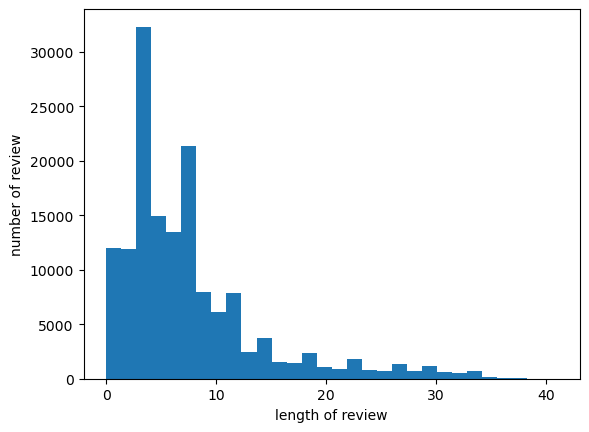

In [26]:
plt.hist([len(review) for review in review_list], bins=30)
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

리뷰 최대 단어 수: 42
리뷰 평균 단어 수: 7.65


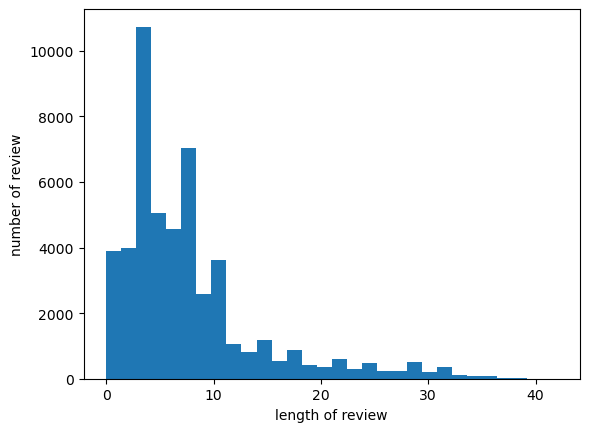

In [28]:
review_list = []
for review in test_df.document:
    review_list.append(review.split())
print(f'리뷰 최대 단어 수: {max(len(review) for review in review_list)}')
print(f'리뷰 평균 단어 수: {sum(map(len, review_list)) / len(review_list):.2f}')

plt.hist([len(review) for review in review_list], bins=30)
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

#### 벡터화

- TF-IDF 벡터화

In [ ]:
tf = TfidfVectorizer(tokenizer= text_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tf.fit(train_df.document)
tf_vect = tf.transform(train_df.document)

#### 감성 분석
- 감성분류 모델 : 로지스틱 회귀
- GridSearchCV로 하이퍼파라미터 튜닝

In [ ]:
lr = LogisticRegression(random_state=0, solver='liblinear')
params = {'C': [1, 3.5, 5.5]}
grid = GridSearchCV(lr, param_grid= params, cv=3, scoring='accuracy', verbose=1)
grid.fit(tf_vect, train_df.label)
print(f'최적의 하이퍼 파라미터: {grid.best_params_}')
print(f'최적의 성능: {grid.best_score_}')

#### 평가

In [ ]:
best_estimator = grid.best_estimator_

tf_test_vect = tf.transform(test_df.document)

pred = best_estimator.predict(tf_test_vect)
pred_proba = best_estimator.predict_proba(tf_test_vect)[:,1]

acc = accuracy_score(test_df.label, pred)
roc_auc = roc_auc_score(test_df.label, pred_proba)

print(f'confusion matrix\n{confusion_matrix(test_df.label, pred)}')
print(classification_report(test_df.label, pred, digits=4))
print(f'Accuracy: {acc:.4f}, ROC_AUC: {roc_auc:.4f}')

------